In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

In [2]:

# ---------- parameters --------------------------------------------------
CLASSES   = ["Top 10 pct", "Bottom 10 pct", "Top 10 aug", "Top 10 aut"]
PERIOD    = 12                                    # monthly seasonality
SEASON_T0 = "2021-08-01"                          # STL window start
SEASON_T1 = "2024-08-31"                          # STL window end
RAW_COL   = "net_jobs"
NORM_COL  = "net_jobs_norm"

In [4]:

# ---------- load / prepare ---------------------------------------------
df = pd.read_csv("data/output/time_series.csv")     # your original dataframe
df = df[df["date"] >= SEASON_T0]                 # keep post-Aug-2021
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)

# normalise: divide by each class mean
df[NORM_COL] = df[RAW_COL] / df.groupby("class")[RAW_COL].transform("mean")

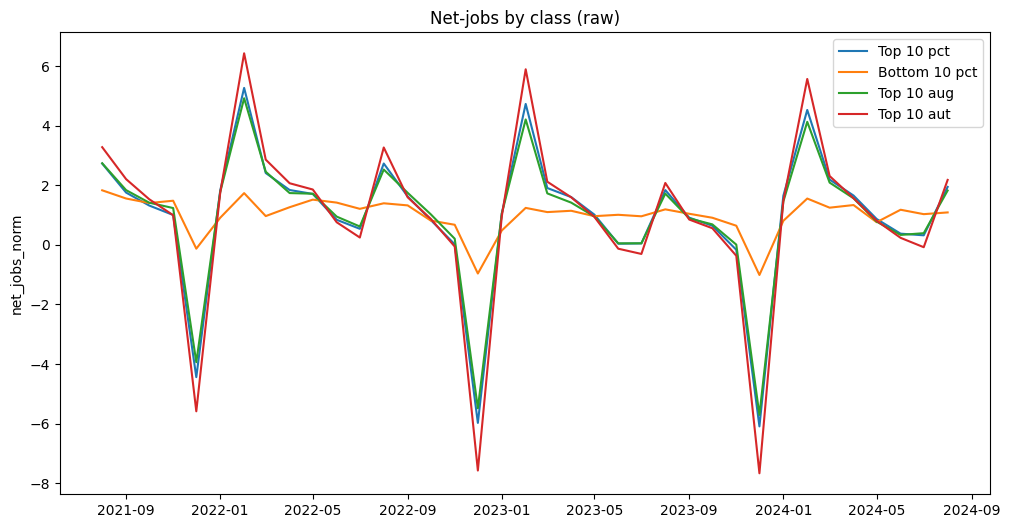

In [5]:

# ────────────────────────────────────────────────────────────────────────
# 1. BASIC PLOT  ▸  raw (normalised) series
# ────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
for cls in CLASSES:
    subset = df[df["class"] == cls]
    plt.plot(subset["date"], subset[NORM_COL], label=cls)
plt.title("Net-jobs by class (raw)")
plt.ylabel(NORM_COL)
plt.legend(); plt.show()

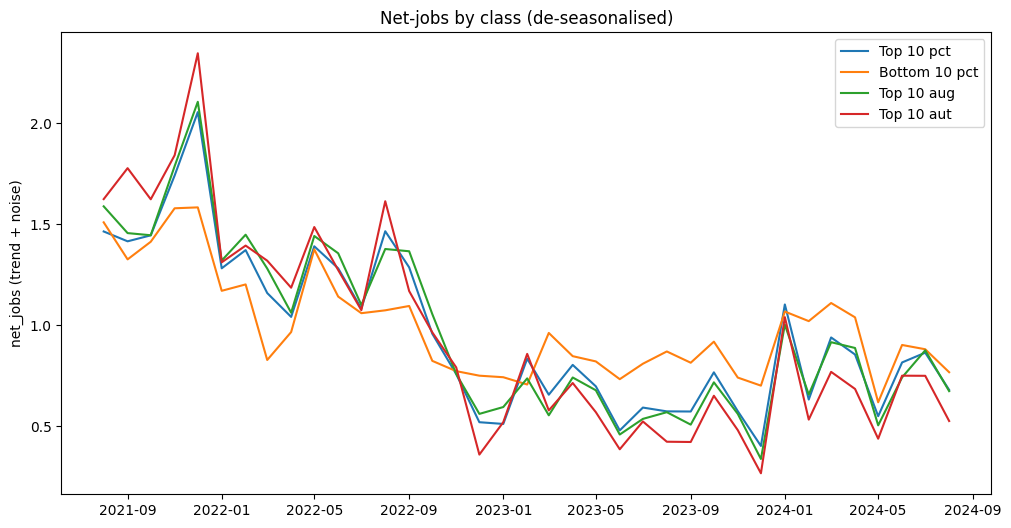

In [6]:
# ────────────────────────────────────────────────────────────────────────
# 2. DE-SEASONALISE  ▸  STL, keep average monthly factor, plot
# ────────────────────────────────────────────────────────────────────────
seasonal_lookup = {}
for cls in CLASSES:
    mask   = (df["class"] == cls) & df["date"].between(SEASON_T0, SEASON_T1)
    series = (df.loc[mask, ["date", NORM_COL]]
                .set_index("date")[NORM_COL]
                .asfreq("MS").interpolate())

    stl    = STL(series, period=PERIOD).fit()
    monthly = (stl.seasonal
               .groupby(stl.seasonal.index.month)
               .mean())          # 12-value Series (Jan … Dec)
    seasonal_lookup[cls] = monthly

# add seasonal factor & de-seasonalised column
df["seasonal"] = df.apply(
    lambda r: seasonal_lookup[r["class"]].loc[r["date"].month], axis=1
)
df["deseas"] = df[NORM_COL] - df["seasonal"]

plt.figure(figsize=(12, 6))
for cls in CLASSES:
    subset = df[df["class"] == cls]
    plt.plot(subset["date"], subset["deseas"], label=cls)
plt.title("Net-jobs by class (de-seasonalised)")
plt.ylabel("net_jobs (trend + noise)")
plt.legend(); plt.show()


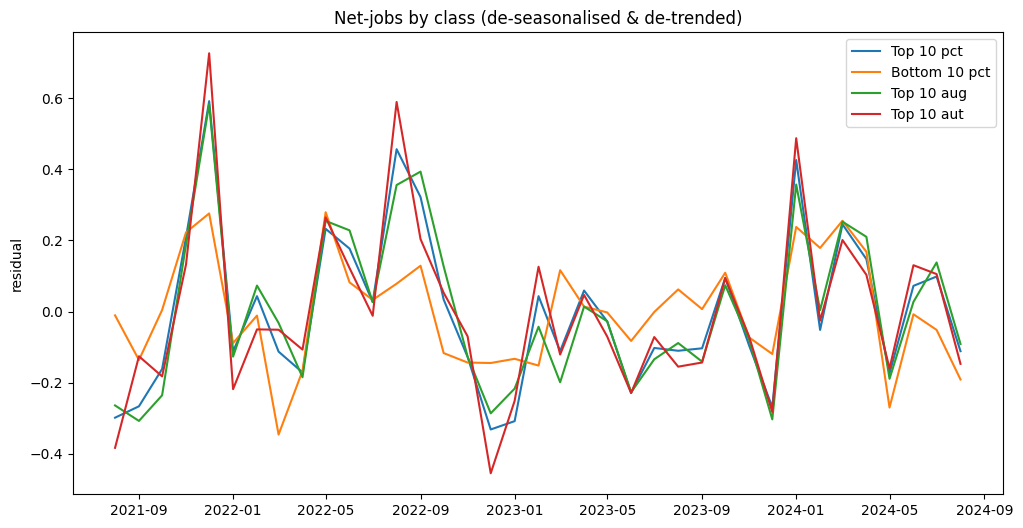

In [7]:
# ────────────────────────────────────────────────────────────────────────
# 3. DE-TREND  ▸  quadratic OLS on deseasonal series, plot residuals
# ────────────────────────────────────────────────────────────────────────
df["t"]    = (df["date"] - df["date"].min()).dt.days / 30.0   # months
df["t_sq"] = df["t"]**2
results = {}        # store OLS + AR models

for cls in CLASSES:
    mask = df["class"] == cls
    y    = df.loc[mask, "deseas"]
    X    = sm.add_constant(df.loc[mask, ["t", "t_sq"]])
    ols  = sm.OLS(y, X).fit()

    df.loc[mask, "detrend_resid"] = ols.resid
    results[cls] = {"trend": ols}

# plot residual (de-seasonalised & de-trended) series
plt.figure(figsize=(12, 6))
for cls in CLASSES:
    subset = df[df["class"] == cls]
    plt.plot(subset["date"], subset["detrend_resid"], label=cls)
plt.title("Net-jobs by class (de-seasonalised & de-trended)")
plt.ylabel("residual")
plt.legend(); plt.show()

In [9]:
# ────────────────────────────────────────────────────────────────────────
# 4. AR MODEL  ▸  choose p by AIC (1…6) on residuals, brief diagnostics
# ────────────────────────────────────────────────────────────────────────
for cls in CLASSES:
    resid = (df.loc[df["class"] == cls, ["date", "detrend_resid"]]
           .set_index("date")["detrend_resid"]
           .asfreq("MS"))      # ensure monthly index
    best_aic, best_p, best_mod = np.inf, None, None

    for p in range(1, 7):
        mod = AutoReg(resid, lags=p, old_names=False).fit()
        if mod.aic < best_aic:
            best_aic, best_p, best_mod = mod.aic, p, mod

    # stationarity / whiteness checks
    p_adf = adfuller(resid, autolag="AIC")[1]
    print(f"{cls}  |  ADF p={p_adf:.3f}  |  chosen AR({best_p})  AIC={best_aic:.2f}")

    results[cls]["ar"]   = best_mod
    results[cls]["p_ar"] = best_p

Top 10 pct  |  ADF p=0.001  |  chosen AR(6)  AIC=-8.75
Bottom 10 pct  |  ADF p=0.000  |  chosen AR(1)  AIC=-28.80
Top 10 aug  |  ADF p=0.000  |  chosen AR(5)  AIC=-9.14
Top 10 aut  |  ADF p=0.482  |  chosen AR(5)  AIC=-2.21


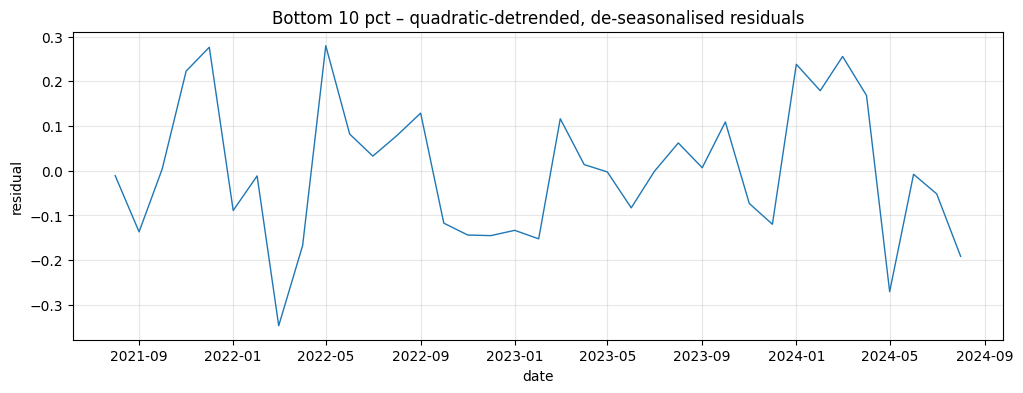

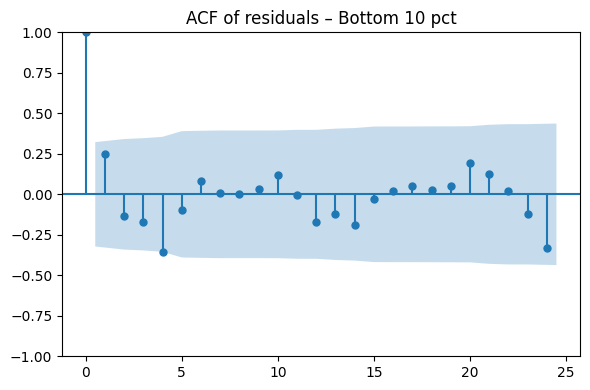

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# ---- isolate the residual series for “Bottom 10 pct” -------------------
mask   = df["class"] == "Bottom 10 pct"
resid  = df.loc[mask, "detrend_resid"].dropna()

# ---- 1) time-series plot of residuals ----------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.loc[mask, "date"], resid, linewidth=1)
plt.title("Bottom 10 pct – quadratic-detrended, de-seasonalised residuals")
plt.ylabel("residual")
plt.xlabel("date")
plt.grid(alpha=0.3)
plt.show()

# ---- 2) autocorrelation function (ACF) ---------------------------------
plt.figure(figsize=(6, 4))
plot_acf(resid, lags=24, ax=plt.gca())   # two years of monthly lags
plt.title("ACF of residuals – Bottom 10 pct")
plt.tight_layout()
plt.show()